In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def preprocess_data(screening_file, final_result_file):
    # Read the CSV files
    screening_df = pd.read_csv(screening_file)
    final_result_df = pd.read_csv(final_result_file)
    
    # Merge the dataframes to identify successful teams
    merged_df = screening_df.merge(
        final_result_df[['TEAM ID', 'Winning Status']], 
        on='TEAM ID', 
        how='left'
    )
    
    # Create binary target variable
    merged_df['is_successful'] = merged_df['Winning Status'].notna().astype(int)
    
    # Select and prepare features
    features = ['ORGANISATION', 'PS CATEGORY', 'COLLEGE', 'NODAL CENTER']
    
    # Encode categorical features
    label_encoders = {}
    for feature in features:
        le = LabelEncoder()
        merged_df[f'{feature}_encoded'] = le.fit_transform(merged_df[feature].astype(str))
        label_encoders[feature] = le
    
    # Prepare feature matrix and target variable
    X = merged_df[[f'{feature}_encoded' for feature in features]]
    y = merged_df['is_successful']
    
    return X, y, label_encoders

def train_random_forest_model(X, y, label_encoders):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    )
    rf_classifier.fit(X_train_scaled, y_train)
    
    # Evaluate the model
    y_pred = rf_classifier.predict(X_test_scaled)
    print("Model Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return rf_classifier, scaler, label_encoders

def predict_team_success_probability(combined_file, model, scaler, label_encoders):
    # Read the combined SIH result file
    combined_df = pd.read_csv(combined_file)
    
    # Prepare features for prediction
    features = ['Organization', 'Name of the Institute', 'City', 'State']
    
    # Encode features using the same label encoders
    encoded_features = []
    for feature in features:
        le = label_encoders.get(feature.upper(), LabelEncoder())  # Default if not found
        combined_df[f'{feature}_encoded'] = le.transform(combined_df[feature].astype(str))
        encoded_features.append(f'{feature}_encoded')
    
    # Scale features
    X_combined = combined_df[encoded_features]
    X_combined_scaled = scaler.transform(X_combined)
    
    # Predict probabilities
    success_probabilities = model.predict_proba(X_combined_scaled)[:, 1]
    
    # Add probabilities to the dataframe
    combined_df['Success_Probability'] = success_probabilities
    
    # Sort and display top 100 teams
    top_teams = combined_df.sort_values('Success_Probability', ascending=False).head(100)
    
    print("\nTop 100 Teams by Success Probability:")
    print(top_teams[['PS ID', 'Team Name', 'Name of the Institute', 'Success_Probability']])
    
    return top_teams

# Main execution
def main():
    # Paths to your CSV files
    screening_file = '2023_screening_result.csv'
    final_result_file = '2023_final_result.csv'
    combined_file = 'combined_sih_results.csv'
    
    # Preprocess data and extract features
    X, y, label_encoders = preprocess_data(screening_file, final_result_file)
    
    # Train Random Forest model
    model, scaler, label_encoders = train_random_forest_model(X, y, label_encoders)
    
    # Predict team success probabilities
    predict_team_success_probability(combined_file, model, scaler, label_encoders)

if __name__ == "__main__":
    main()


Model Accuracy: 0.6551724137931034

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       197
           1       0.12      0.06      0.08        64

    accuracy                           0.66       261
   macro avg       0.43      0.46      0.43       261
weighted avg       0.58      0.66      0.61       261



FileNotFoundError: [Errno 2] No such file or directory: 'combined_sih_result.csv'

Random Forest Feature Importance:


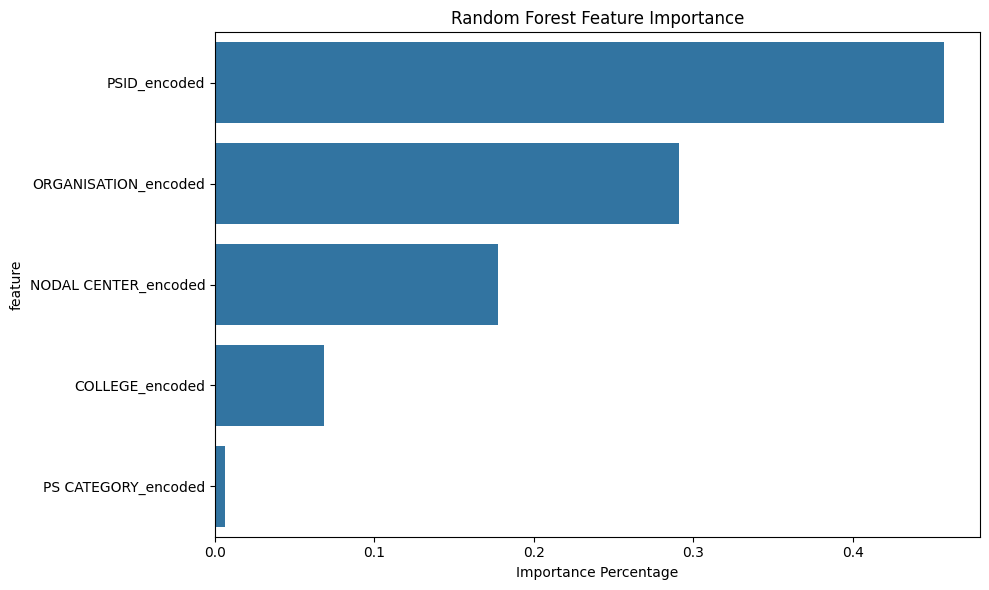

                feature  importance
1          PSID_encoded    0.456915
0  ORGANISATION_encoded    0.291290
4  NODAL CENTER_encoded    0.177171
3       COLLEGE_encoded    0.068562
2   PS CATEGORY_encoded    0.006062


<Figure size 2000x2000 with 0 Axes>

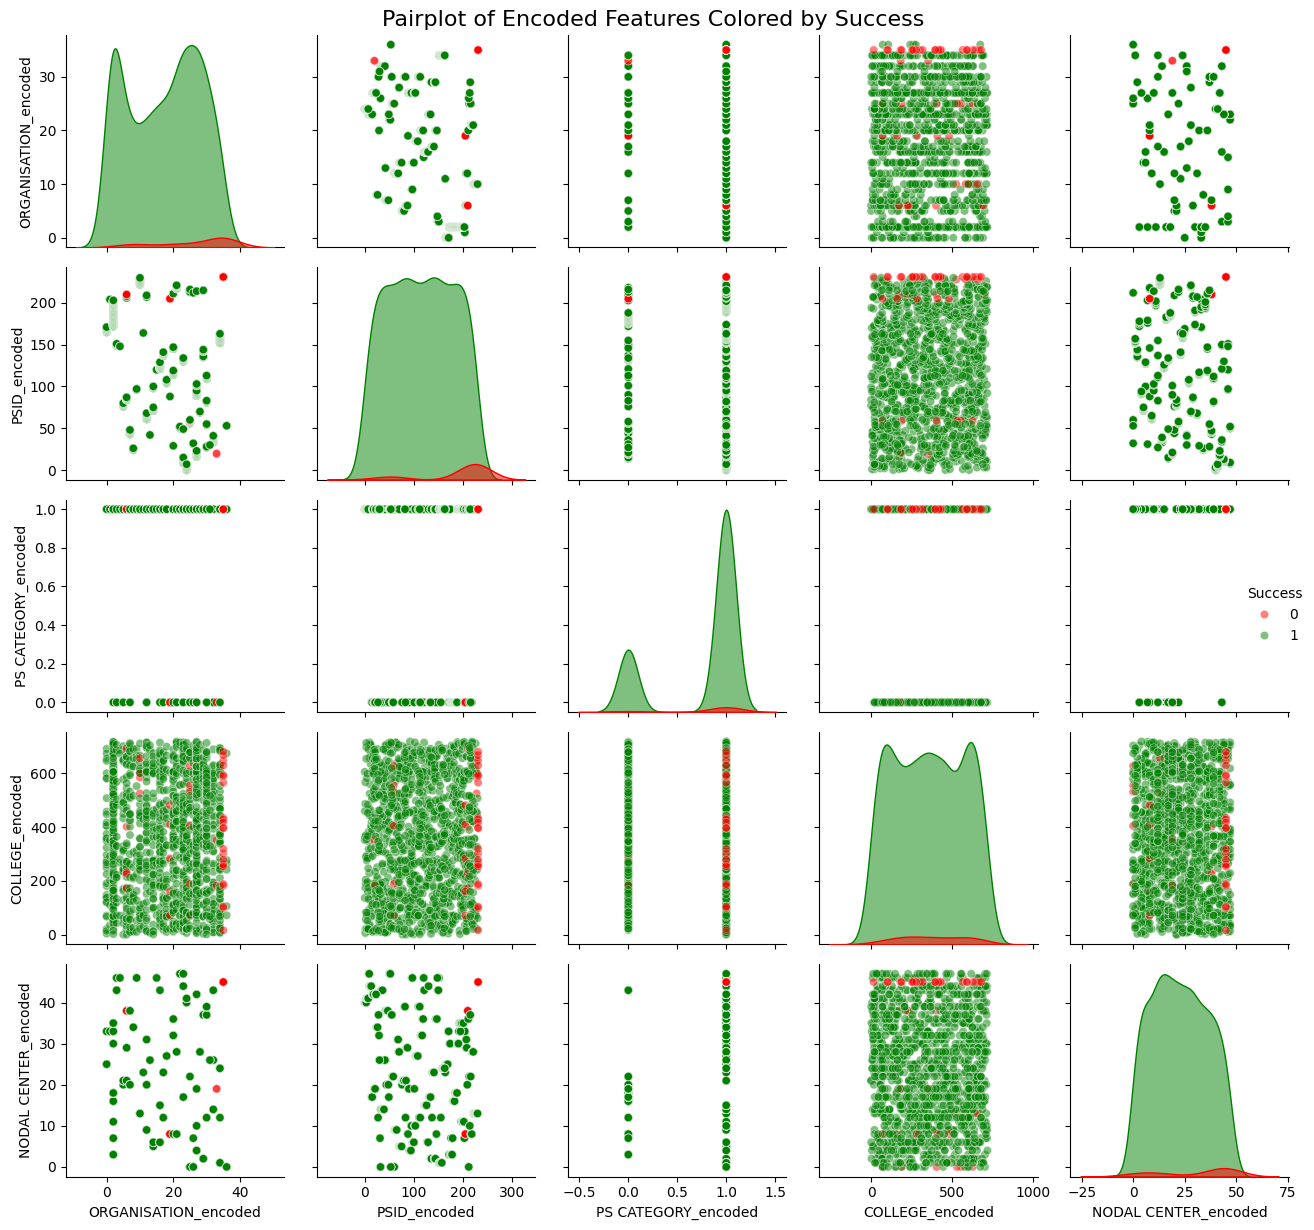

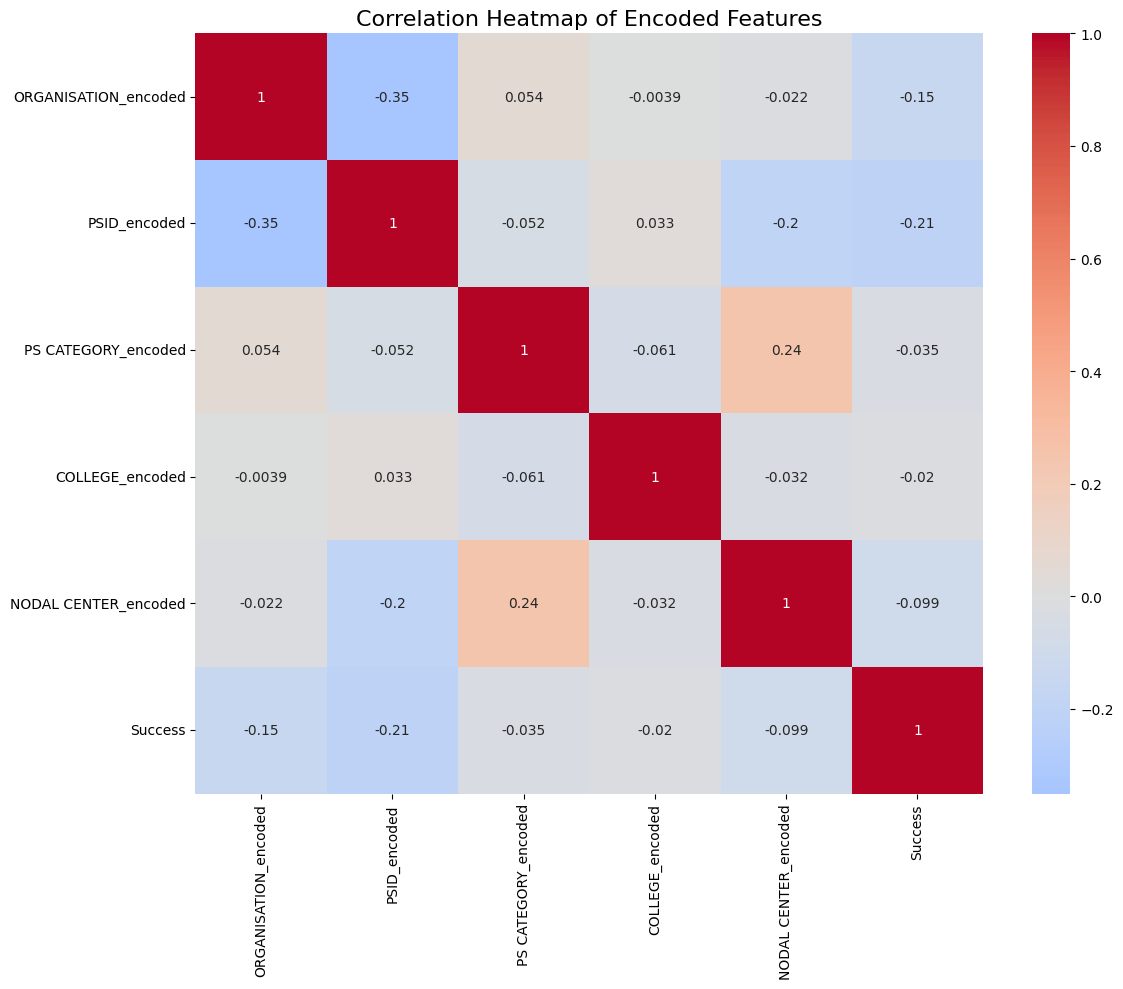

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

def load_and_preprocess_data(screening_file, final_result_file):
    """
    Load and preprocess the SIH 2023 dataset
    """
    # Load CSV files
    screening_df = pd.read_csv(screening_file)
    final_result_df = pd.read_csv(final_result_file)
    
    # Create a success column based on presence in winners
    screening_df['Success'] = screening_df.apply(
        lambda row: 1 if any(
            (row['PSID'] == winner['PSID']) & 
            (row['ORGANISATION'] == winner['ORGANISATION']) 
            for _, winner in final_result_df.iterrows()
        ) else 0, 
        axis=1
    )
    
    # Select relevant features
    features_to_use = [
        'ORGANISATION', 'PSID', 'PS CATEGORY', 
        'COLLEGE', 'NODAL CENTER'
    ]
    
    # Label Encoding for categorical variables
    le = LabelEncoder()
    for col in features_to_use:
        screening_df[f'{col}_encoded'] = le.fit_transform(screening_df[col])
    
    # Prepare feature matrix and target
    X = screening_df[[f'{col}_encoded' for col in features_to_use]]
    y = screening_df['Success']
    
    return X, y, screening_df

def random_forest_feature_importance(X, y):
    """
    Perform Random Forest Feature Importance Analysis
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    
    # Feature Importance
    feature_importance = rf_classifier.feature_importances_
    feature_names = X.columns
    
    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Visualization of Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Random Forest Feature Importance')
    plt.xlabel('Importance Percentage')
    plt.tight_layout()
    plt.show()
    
    return importance_df, rf_classifier

def visualize_feature_relationships(X, y):
    """
    Create Pairplot and Correlation Heatmap
    """
    # Combine features with success column for visualization
    plot_df = X.copy()
    plot_df['Success'] = y
    
    # 1. Pairplot with Success Coloring
    plt.figure(figsize=(20, 20))
    g = sns.pairplot(plot_df, hue='Success', 
                     plot_kws={'alpha': 0.5},
                     diag_kws={'alpha': 0.5},
                     palette=['red', 'green'])
    g.fig.suptitle('Pairplot of Encoded Features Colored by Success', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 2. Correlation Heatmap
    plt.figure(figsize=(12, 10))
    correlation_matrix = plot_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Heatmap of Encoded Features', fontsize=16)
    plt.tight_layout()
    plt.show()

def main():
    # File paths
    screening_file = '2023_screening_result.csv'
    final_result_file = '2023_final_result.csv'
    
    # Load and preprocess data
    X, y, _ = load_and_preprocess_data(screening_file, final_result_file)
    
    # 1. Random Forest Feature Importance
    print("Random Forest Feature Importance:")
    feature_importance, rf_model = random_forest_feature_importance(X, y)
    print(feature_importance)
    
    # 2. Feature Relationship Visualization
    visualize_feature_relationships(X, y)

# Run the analysis
if __name__ == '__main__':
    main()